<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "1C"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/1C/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


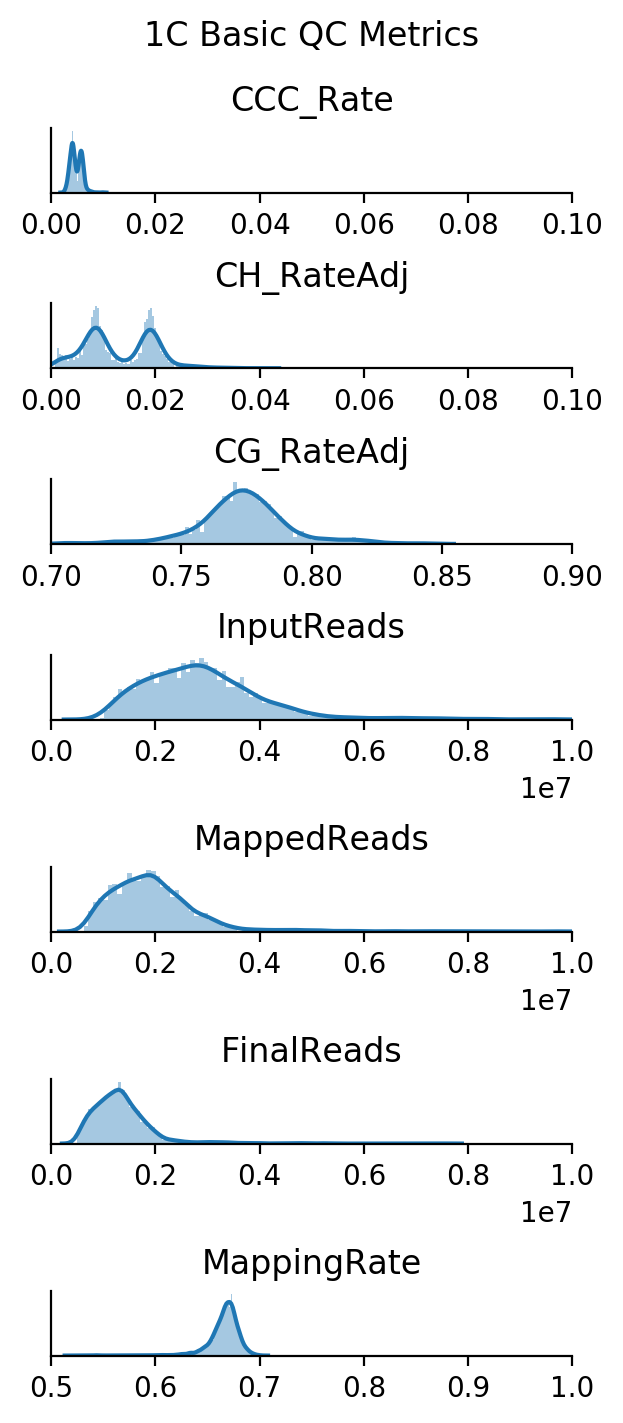

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

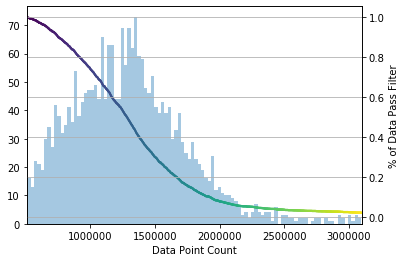

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2432/2432 (100.0%)
CG_RateAdj passed 2432/2432 (100.0%)
CH_RateAdj passed 2432/2432 (100.0%)
FinalReads passed 2432/2432 (100.0%)
MappingRate passed 2432/2432 (100.0%)
Overall passed 2432/2432 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180208 1287
180212 1145


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 295 76.8%
ad002 312 81.2%
ad004 315 82.0%
ad006 306 79.7%
ad007 307 79.9%
ad008 311 81.0%
ad010 294 76.6%
ad012 292 76.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
1C_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00522,0.76831,0.76709,0.02300,0.01787,1080479.0,2522464,1581603.0,1C,...,-1.106384,4.519074,37.032401,-43.513147,OLF-Exc Bmpr1b,11.379993,-5.368651,22.321038,-21.032908,True
1C_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00560,0.81235,0.81129,0.02586,0.02037,966716.0,2241496,1420965.0,1C,...,2.711604,3.807416,31.557470,-32.961447,OLF-Exc Bmpr1b,9.925430,-10.633616,-11.452207,-37.620835,True
1C_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00620,0.79049,0.78918,0.02803,0.02197,2059770.0,4558890,3129228.0,1C,...,0.493789,4.812925,32.211425,-38.877724,OLF-Exc Bmpr1b,9.766440,-7.472024,10.527339,-20.480752,True
1C_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00564,0.77285,0.77156,0.02439,0.01886,1165802.0,2550750,1736845.0,1C,...,-0.636906,4.897202,32.901177,-42.818722,OLF-Exc Bmpr1b,10.871809,-6.217155,19.602548,-21.920361,True
1C_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00392,0.73203,0.73098,0.00584,0.00193,1893564.0,4320062,2805118.0,1C,...,-10.996495,-8.156301,-18.780081,18.327461,OPC opc-large,1.331524,3.401326,-2.250564,3.066267,True
1C_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00608,0.77446,0.77308,0.02458,0.01861,1812430.0,4001782,2691600.0,1C,...,-0.537039,3.597137,40.999881,-39.630763,OLF-Exc Bmpr1b,12.414266,-6.983006,19.489150,-28.105710,True
1C_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00378,0.75051,0.74956,0.00943,0.00567,1699327.0,3810146,2545268.0,1C,...,1.298773,-4.764727,-0.393909,-42.741823,OLF Trpc4,0.087732,18.471634,-1.382776,-21.813442,True
1C_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00605,0.79974,0.79852,0.02522,0.01929,1533511.0,3478606,2313810.0,1C,...,2.233578,4.050862,31.477669,-33.628106,OLF-Exc Bmpr1b,9.937396,-10.347886,-11.106575,-37.326791,True
1C_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00462,0.77814,0.77711,0.01398,0.00940,1621539.0,3722754,2464510.0,1C,...,-1.709238,-2.600392,-10.798388,-34.859902,OLF Trpc4,4.904696,14.069795,2.052773,-0.021665,True
1C_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/1C/CEMBA180208_1C...,0.00613,0.78293,0.78159,0.02485,0.01884,1456094.0,3394176,2245634.0,1C,...,1.210558,3.337716,35.989888,-36.177108,OLF-Exc Bmpr1b,11.836699,-8.619569,12.908525,-26.973023,True
